# I thought the last notebook was my final for modeling...

### Amanda discovered some new info on data collection late last night that suggests the feature "lga" might give us better results than "basin".
#### Time to find out if that is true.

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#additional EDA
from pandas_profiling import ProfileReport

# Model selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, plot_confusion_matrix, classification_report

# Ensemble/XGBoost
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

# Visualizing
from sklearn.tree import export_graphviz
from IPython.display import Image  
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
from sklearn.tree import plot_tree

### Reading in the geodata_clean csv... Amanda's research showed that some observations needed to be dropped. see README for details.

In [2]:
df = pd.read_csv("../geodata_clean.csv")
df.head()

,Unnamed: 0,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,geometry,x,y
0,0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,...,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,POINT (34.93809275 -9.856321769999999),34.938093,-9.856322
1,1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,...,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,POINT (34.6987661 -2.14746569),34.698766,-2.147466
2,2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,...,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,POINT (37.46066446 -3.82132853),37.460664,-3.821329
3,3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,...,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,POINT (38.48616088 -11.15529772),38.486161,-11.155298
4,4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,...,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,POINT (31.13084671 -1.82535885),31.130847,-1.825359


Making my smaller data frame with our chosen features.
In this version I will substitute "lga" for "basin", and add "management_group"

In [3]:
st_df = df[['status_group','lga','quantity_group','quality_group','management_group',
            'extraction_type','source_type','waterpoint_type']]
st_df.head()

,status_group,lga,quantity_group,quality_group,management_group,extraction_type,source_type,waterpoint_type
0,functional,Ludewa,enough,good,user-group,gravity,spring,communal standpipe
1,functional,Serengeti,insufficient,good,user-group,gravity,rainwater harvesting,communal standpipe
2,functional,Simanjiro,enough,good,user-group,gravity,dam,communal standpipe multiple
3,non functional,Nanyumbu,dry,good,user-group,submersible,borehole,communal standpipe multiple
4,functional,Karagwe,seasonal,good,other,gravity,rainwater harvesting,communal standpipe


In [4]:
# identify target and features
# target variable
y = st_df['status_group']
# features
X = st_df.drop('status_group', axis=1)

train test split with .25 test size

In [5]:
# time for a train test split and a new model or two

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.2)

In [6]:
#encode the categoricals
ohe = OneHotEncoder(drop='first')

ohe.fit(X_train)
X_train_ohe = ohe.transform(X_train).toarray()

# Creating this DataFrame is only to show the result of the ohe
ohe_df = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names(X_train.columns))

### We decided Random Forest Classifier gave us the best result

    Instantiate.

In [7]:
# Instantiate a RandomForestClassifier
rfc1 = RandomForestClassifier(n_estimators=500, random_state=42)

    Fit.

In [8]:
rfc1.fit(X_train_ohe, y_train)

RandomForestClassifier(n_estimators=500, random_state=42)

    Predict.

In [9]:
rfc1_preds = rfc1.predict(X_train_ohe)

    Return scores.

In [10]:
def display_scores(true, preds, model_name):
    """Returns a function running metric scores, classification_report, and confusion_matrix for a model."""
    rec = recall_score(true, preds, average='micro')
    acc = accuracy_score(true, preds)
    f1 = f1_score(true, preds, average='micro', zero_division=0)
    prec = precision_score(true, preds, average='micro', zero_division=0)
    rc = classification_report(true, preds)
    cm = confusion_matrix(true, preds)
    
    print("Model: {}".format(model_name))
    print("Recall: {}".format(rec))
    print("Accuracy: {}".format(acc))
    print("F1-Score: {}".format(f1))
    print("Precision: {}".format(prec))
    print("Classification Report:\n {}".format(rc))
    print("Confusion Matrix:\n {}".format(cm))
    print("--------------------------------------------------------------------------------")
    

    return display_scores


In [11]:
display_scores(y_train, rfc1_preds , model_name='Random Forest 1')

Model: Random Forest 1
Recall: 0.8049706967657911
Accuracy: 0.8049706967657911
F1-Score: 0.8049706967657911
Precision: 0.8049706967657911
Classification Report:
                          precision    recall  f1-score   support

             functional       0.79      0.91      0.85     25088
functional needs repair       0.64      0.27      0.38      3140
         non functional       0.84      0.75      0.79     17842

               accuracy                           0.80     46070
              macro avg       0.76      0.64      0.67     46070
           weighted avg       0.80      0.80      0.79     46070

Confusion Matrix:
 [[22880   254  1954]
 [ 1787   837   516]
 [ 4252   222 13368]]
--------------------------------------------------------------------------------


<function __main__.display_scores(true, preds, model_name)>

    Plot confusion matrix.

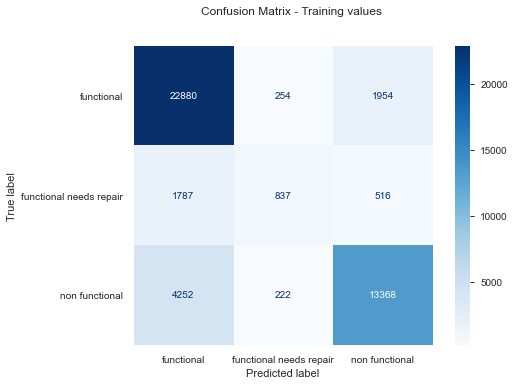

In [12]:
fig, ax = plt.subplots()
fig.suptitle("Confusion Matrix - Training values")
plot_confusion_matrix(rfc1, X_train_ohe, y_train, ax=ax, cmap="Blues");

result: Overall a better score than the models in my previous noteboo, especially recall for non-functional wells!
    

In [13]:
for col, feature in zip(ohe_df.columns, rfc1.feature_importances_):
    print(col,",", feature)

lga_Arusha Urban , 0.0005626119777887173
lga_Babati , 0.0027755680147985634
lga_Bagamoyo , 0.003736473315384184
lga_Bahi , 0.001786042756337658
lga_Bariadi , 0.002449995428159126
lga_Biharamulo , 0.0020645419856792774
lga_Bukoba Rural , 0.003209440188410444
lga_Bukoba Urban , 0.0010009004155354204
lga_Bukombe , 0.0019198875264989721
lga_Bunda , 0.0037342671556000874
lga_Chamwino , 0.0027790987271736982
lga_Chato , 0.002236211291343306
lga_Chunya , 0.006843237406188862
lga_Dodoma Urban , 0.0030277055047521267
lga_Hai , 0.002713824796442274
lga_Hanang , 0.0024859046267782336
lga_Handeni , 0.0015569662254757864
lga_Igunga , 0.0035225169513514983
lga_Ilala , 0.002983356273785523
lga_Ileje , 0.0027774683958573924
lga_Ilemela , 0.0012296177825650023
lga_Iramba , 0.0029151026521628733
lga_Iringa Rural , 0.0035596212937738284
lga_Kahama , 0.006410195262223765
lga_Karagwe , 0.0034279239762311352
lga_Karatu , 0.004410018644298297
lga_Kasulu , 0.006339386527085636
lga_Kibaha , 0.00231608753954783

### Testing

In [14]:
#encode the test set
X_test_ohe = ohe.transform(X_test)

#fit
rfc1.fit(X_test_ohe, y_test)
#predict
y1_preds = rfc1.predict(X_test_ohe)
#check scores
display_scores(y_test, y1_preds , model_name='Random Forest Test 1');

Model: Random Forest Test 1
Recall: 0.8286160791804132
Accuracy: 0.8286160791804132
F1-Score: 0.8286160791804132
Precision: 0.8286160791804132
Classification Report:
                          precision    recall  f1-score   support

             functional       0.81      0.93      0.87      6301
functional needs repair       0.73      0.36      0.48       791
         non functional       0.87      0.77      0.82      4426

               accuracy                           0.83     11518
              macro avg       0.80      0.69      0.72     11518
           weighted avg       0.83      0.83      0.82     11518

Confusion Matrix:
 [[5833   63  405]
 [ 381  284  126]
 [ 955   44 3427]]
--------------------------------------------------------------------------------


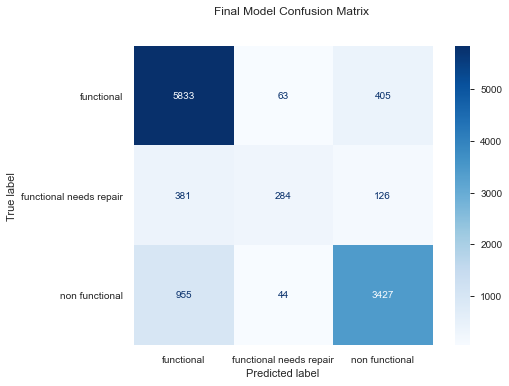

In [15]:
fig, ax = plt.subplots()
figsize=(20,20)
fig.suptitle("Final Model Confusion Matrix")
plot_confusion_matrix(rfc1, X_test_ohe, y_test, ax=ax, cmap="Blues");